In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='0'

import shutup
shutup.please()

import jax
import jax.numpy as jnp
import numpy as np

# VIZ
import matplotlib.pyplot as plt
from rich.pretty import pprint
from tqdm.auto import tqdm

from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

GLOBAL_KEY = jax.random.key(42)
START_POS = (1,1)

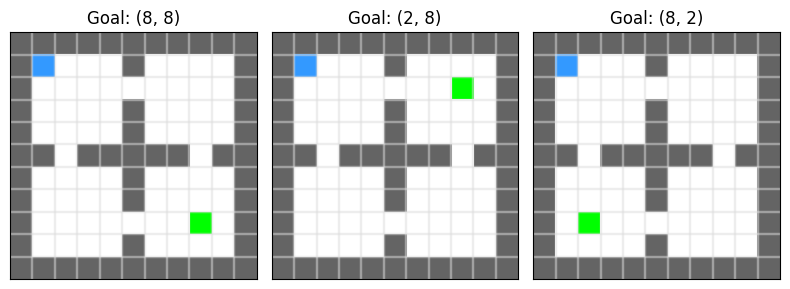

In [2]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

test = FourRoomsMazeEnv(Maze(seed=0))
test.reset()
img = test.render(return_img=True)

fig, ax = plt.subplots(nrows=1, ncols=3)
for i, cur_ax in enumerate(ax.flat, start=0):
    test.setup_goals(seed=None, task_num=i, start_pos=START_POS)
    test.render(ax=cur_ax)
    cur_ax.set_title(f"Goal: {test.goal}")
plt.tight_layout()


# Data Collection

  0%|          | 0/1 [00:00<?, ?it/s]

{
│   'actions': (300000,),
│   'layout_type': (300000, 1),
│   'next_observations': (300000, 2),
│   'observations': (300000, 2),
│   'terminals': (300000,)
}

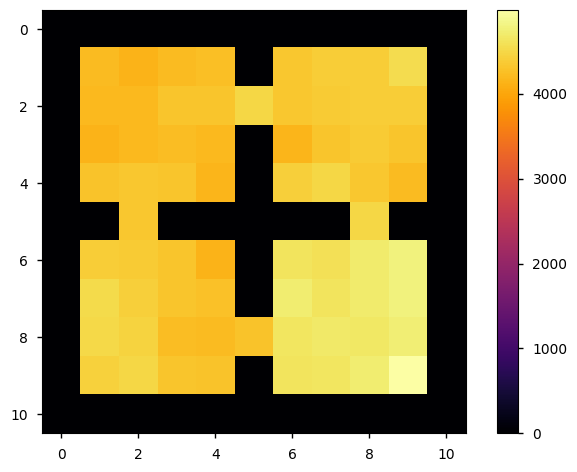

In [3]:
from envs.minigrid.env_utils import random_exploration_fourrooms, q_learning

train_layout_data = []

NUM_TRAIN_LAYOUTS = 1
NUM_TRAIN_STEPS = 100
NUM_TRAIN_EPISODES = 3000
seeds = np.arange(0, NUM_TRAIN_LAYOUTS)

if NUM_TRAIN_LAYOUTS > 1:
    for i in tqdm(range(NUM_TRAIN_LAYOUTS)):
        env = FourRoomsMazeEnv(Maze(seed=seeds[i], maze_type='fourrooms_random_layouts'), max_steps=NUM_TRAIN_STEPS)
        dataset, env = random_exploration_fourrooms(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, num_mdp=NUM_TRAIN_LAYOUTS)
        train_layout_data.append(dataset)
else:
    for i in tqdm(range(1)):
        env = FourRoomsMazeEnv(Maze(seed=seeds[i]), max_steps=NUM_TRAIN_STEPS)
        dataset, env = random_exploration_fourrooms(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, num_mdp=NUM_TRAIN_LAYOUTS)
        train_layout_data.append(dataset)
        
pprint(jax.tree.map(lambda x: x.shape, train_layout_data[0]))

coverage_map = np.zeros(shape=env.maze.size)
for layout in train_layout_data:
    for obs in layout['observations']:
        obs = obs.astype(np.int16)
        coverage_map[obs[1], obs[0]] += 1
        
plt.imshow(coverage_map, cmap='inferno', vmin=0)
plt.colorbar()
plt.show()

# Initialize Vanilla-FB

In [4]:
import functools
from utils.datasets import Dataset, GCDataset

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=fb_vanilla_discrete_4rooms.yaml',
                                                            f'agent.z_dim=150',
                                                            f'agent.z_mix_ratio=0.5'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)

print(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])

{
│   'seed': 42,
│   'run_group': 'fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 150000,
│   'log_interval': 10000,
│   'eval_interval': 30000,
│   'eval_tasks': None,
│   'eval_episodes': 20,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'z_dim': 150,
│   │   'z_mix_ratio': 0.5,
│   │   'boltzmann': True,
│   │   'f_hidden_dims': [1024, 512, 512],
│   │   'f_layer_norm': True,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True,
│   │   'use_context': False
│   },
│   'env': {'env_name': 'fourrooms-vanilla', 'discrete': True},
│   'tags': ['vanilla-fb', '4rooms', 'discrete']
}

{'actions': (300000,), 'layout_type': (300000, 1), 'next_observations': (300000, 2), 'observations': (300000, 2), 'terminals': (300000,)}


In [5]:
sys.path.append("..")
from agents.fb import ForwardBackwardAgent

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.action_space.n - 1),
    config=fb_config['agent']
)
fb_agent, info = fb_agent.update(gc_whole_dataset.sample(512))

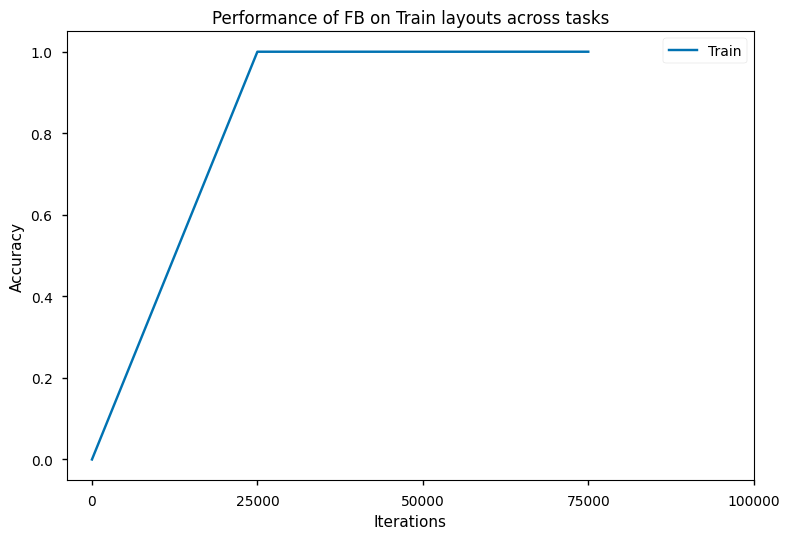

In [ ]:
from envs.custom_mazes.env_utils import policy_image_fourrooms, value_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng, add_to, flatten
from IPython.display import clear_output
from envs.env_utils import EpisodeMonitor
from collections import defaultdict
import numpy as np

def evaluate_fourrooms(
    agent,
    env,
    task_id=None,
    config=None,
    num_eval_episodes=10,
    num_video_episodes=0,
    video_frame_skip=3,
    eval_temperature=0.0,
    eval_gaussian=None,
):

    actor_fn = supply_rng(agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32)))
    trajs = []
    stats = defaultdict(list)
    pbar = range(num_eval_episodes + num_video_episodes)
    renders = []
    for i in pbar:
        traj = defaultdict(list)
        should_render = i >= num_eval_episodes
        observation, info = env.unwrapped.setup_goals(seed=None, task_num=task_id, start_pos=START_POS)
        goal = info.get("goal_pos", None)
        done = False
        step = 0
        render = []
        latent_z = agent.infer_z(goal)

        while not done:
            action = actor_fn(observations=observation, latent_z=latent_z, temperature=eval_temperature)
            next_observation, reward, terminated, truncated, info = env.step(jax.device_get(action.squeeze()))
            done = terminated or truncated
            step += 1

            if should_render and (step % video_frame_skip == 0 or done):
                # frame = env.unwrapped.render(return_img=True).copy()
                render.append(env.unwrapped.render(return_img=True).copy())

            transition = dict(
                observation=observation,
                next_observation=next_observation,
                action=action,
                reward=reward,
                done=done,
                info=info,
            )
            add_to(traj, transition)
            observation = next_observation
        if i < num_eval_episodes:
            add_to(stats, flatten(info))
            trajs.append(traj)
        else:
            renders.append(np.array(render))

    for k, v in stats.items():
        stats[k] = np.mean(v)

    return stats, trajs, renders

def visualize_value_image(task_num):
    env = FourRoomsMazeEnv(Maze(seed=0))
    env.reset()
    observation, info = env.setup_goals(seed=None, task_num=task_num, start_pos=START_POS)
    goal = info.get("goal_pos", None)
    latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
    N, M = env.maze.size
    pred_value_img = value_image_fourrooms(env, example_batch, N=N, M=M,
                                value_fn=partial(fb_agent.predict_q, z=latent_z), goal=goal)
    return pred_value_img

def visualize_policy(task_num):
    env = FourRoomsMazeEnv(Maze(seed=0))
    env.reset()
    observation, info = env.setup_goals(seed=None, task_num=task_num, start_pos=START_POS)
    goal = info.get("goal_pos", None)
    latent_z = fb_agent.infer_z(goal)
    start = info.get("start_pos", None)
    example_batch = whole_dataset.sample(1)
    pred_policy_img = policy_image_fourrooms(env, example_batch, N=env.maze.size[0], M=env.maze.size[1],
                                                    action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                                    goal=goal, start=start)
    return pred_policy_img

training_steps = 100_001
pbar = tqdm(range(training_steps))
env = FourRoomsMazeEnv(Maze(seed=0), max_steps=NUM_TRAIN_STEPS)
# q = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
eval_history_train = []
eval_history_test = []

for update_step in pbar:
    batch = gc_whole_dataset.sample(1024)
    fb_agent, info = fb_agent.update(batch)
    
    if update_step % 10_000 == 0:
        clear_output()
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
        pred_policy_img = visualize_policy(task_num=2)
        ax[0].imshow(pred_policy_img)
        pred_value_img = visualize_value_image(task_num=2)
        ax[1].imshow(pred_value_img)
        
        fig.suptitle(f"Training step: {update_step}")   
        plt.tight_layout()
        display(fig)
        plt.close(fig)
    
    if update_step % 25_000 == 0:
        clear_output()
        fig, ax = plt.subplots()
        # ax.plot(eval_history_test, label='Test')
        ax.plot(eval_history_train, label='Train')
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Accuracy")
        ax.set_xticks(np.arange(len(np.arange(training_steps, step=25_000))), labels=np.arange(training_steps, step=25_000))
        plt.legend()
        plt.title("Performance of FB on Train layouts across tasks")
        plt.tight_layout()
        display(fig)
        plt.close(fig)
        
        eval_metrics = {}
        overall_metrics = defaultdict(list)
        
        for task_id in range(3):
            for env_id in range(NUM_TRAIN_LAYOUTS):
                env = FourRoomsMazeEnv(Maze(seed=env_id), NUM_TRAIN_STEPS)
                env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
                # env.reset(options={"start": (1, 1)})
                eval_info, _, _ = evaluate_fourrooms(
                        agent=fb_agent,
                        env=env,
                        task_id=task_id,
                        config=None,
                        num_eval_episodes=10,
                        num_video_episodes=0,
                        video_frame_skip=1,
                        eval_temperature=0.0,
                        eval_gaussian=None
                    )
                eval_metrics.update(
                    {f'evaluation/task_{task_id}_{k}': v for k, v in eval_info.items() if k != 'total.timesteps'}
                )
                for k, v in eval_info.items():
                    overall_metrics[k].append(v)
                    
        for k, v in overall_metrics.items():
            eval_metrics[f'evaluation/overall_{k}_train'] = np.mean(v)
            
        eval_history_train.append(eval_metrics['evaluation/overall_episode.final_reward_train'])

        # eval_metrics = {}
        # overall_metrics = defaultdict(list)

        # for task_id in range(3):
        #     for env_id in range(NUM_TRAIN_LAYOUTS+50, NUM_TRAIN_LAYOUTS + 60):
        #         env = FourRoomsMazeEnv(Maze(seed=env_id), max_steps=NUM_TRAIN_STEPS)
        #         env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
        #         # env.reset(options={"start": (1, 1)})
        #         eval_info, _, _ = evaluate_fourrooms(
        #                 agent=fb_agent,
        #                 env=env,
        #                 task_id=task_id,
        #                 config=None,
        #                 num_eval_episodes=10,
        #                 num_video_episodes=0,
        #                 video_frame_skip=1,
        #                 eval_temperature=0.0,
        #                 eval_gaussian=None
        #             )
        #         eval_metrics.update(
        #             {f'evaluation/task_{task_id}_{k}': v for k, v in eval_info.items() if k != 'total.timesteps'}
        #             )
        #         for k, v in eval_info.items():
        #             overall_metrics[k].append(v)
                    
        # for k, v in overall_metrics.items():
        #     eval_metrics[f'evaluation/overall_{k}_ood'] = np.mean(v)
        # eval_history_test.append(eval_metrics['evaluation/overall_episode.final_reward_ood'])
        


TypeError: '<' not supported between instances of 'XTick' and 'XTick'

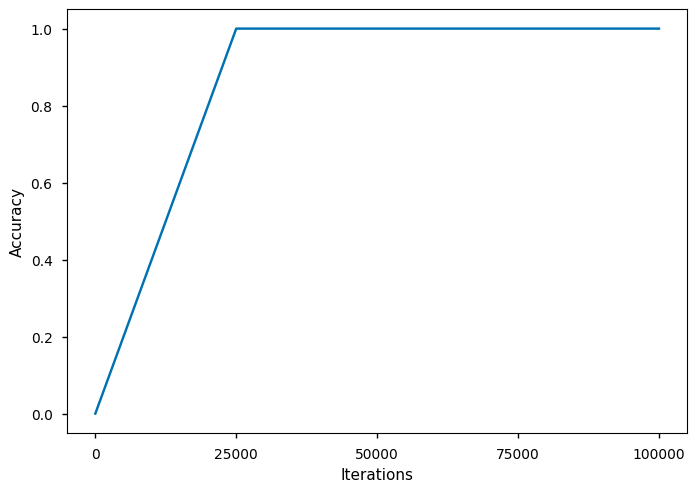

In [ ]:
# Final
fig, ax = plt.subplots()
ax.plot(eval_history_train, label='Train')
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
ax.set_xticks(ax.set_xticks(np.arange(len(np.arange(training_steps, step=25_000))),
                            labels=np.arange(training_steps, step=25_000)), labels=np.arange(training_steps, step=25_000))
plt.legend()
plt.title("Performance of FB on Train layouts across tasks")

In [ ]:
# # RANDOM
# from tqdm import trange

# def evaluate_fourrooms(
#     env,
#     task_id=None,
#     config=None,
#     num_eval_episodes=10,
#     num_video_episodes=0,
#     video_frame_skip=3,
#     eval_temperature=0.0,
#     eval_gaussian=None,
# ):
#     trajs = []
#     stats = defaultdict(list)
#     pbar = trange(num_eval_episodes + num_video_episodes, leave=False, colour='red', position=2)
#     renders = []
#     for i in pbar:
#         traj = defaultdict(list)
#         should_render = i >= num_eval_episodes
#         observation, info = env.unwrapped.setup_goals(seed=None, task_num=task_id, start_pos=START_POS)
#         goal = info.get("goal_pos", None)
#         done = False
#         step = 0
#         render = []
#         while not done:
#             action = env.action_space.sample()
#             next_observation, reward, terminated, truncated, info = env.step(jax.device_get(action.squeeze()))
#             done = terminated or truncated
#             step += 1

#             if should_render and (step % video_frame_skip == 0 or done):
#                 frame = env.unwrapped.render(return_img=True).copy()
#                 render.append(frame)

#             transition = dict(
#                 observation=observation,
#                 next_observation=next_observation,
#                 action=action,
#                 reward=reward,
#                 done=done,
#                 info=info,
#             )
#             add_to(traj, transition)
#             observation = next_observation
#         if i < num_eval_episodes:
#             add_to(stats, flatten(info))
#             trajs.append(traj)
#         else:
#             renders.append(np.array(render))

#     for k, v in stats.items():
#         stats[k] = np.mean(v)

#     return stats, trajs, renders

# eval_metrics = {}
# overall_metrics = defaultdict(list)
# eval_history_train = []
# eval_history_test = []
# for task_id in range(2, 5): # static for 4 rooms
#     for env_id in range(NUM_TRAIN_LAYOUTS):
#         env = FourRoomsMazeEnv(Maze(seed=env_id, maze_type='fourrooms_random_layouts'), NUM_TRAIN_STEPS)
#         env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
#         # env.reset(options={"start": (1, 1)})
#         eval_info, _, _ = evaluate_fourrooms(
#                 env=env,
#                 task_id=task_id,
#                 config=None,
#                 num_eval_episodes=10,
#                 num_video_episodes=0,
#                 video_frame_skip=1,
#                 eval_temperature=0.0,
#                 eval_gaussian=None
#             )
#         eval_metrics.update(
#             {f'evaluation/task_{task_id}_{k}': v for k, v in eval_info.items() if k != 'total.timesteps'}
#         )
#         for k, v in eval_info.items():
#             overall_metrics[k].append(v)
            
# for k, v in overall_metrics.items():
#     eval_metrics[f'evaluation/overall_{k}_train'] = np.mean(v)
    
# eval_history_train.append(eval_metrics['evaluation/overall_episode.final_reward_train'])

# eval_metrics = {}
# overall_metrics = defaultdict(list)
            
# for task_id in range(2, 5):
#     for env_id in range(100, 110):
#         env = FourRoomsMazeEnv(Maze(seed=env_id, maze_type='fourrooms_random_layouts'), max_steps=NUM_TRAIN_STEPS)
#         env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
#         # env.reset(options={"start": (1, 1)})
#         eval_info, _, _ = evaluate_fourrooms(
#                 env=env,
#                 task_id=task_id,
#                 config=None,
#                 num_eval_episodes=10, ##
#                 num_video_episodes=0,
#                 video_frame_skip=1,
#                 eval_temperature=0.0,
#                 eval_gaussian=None
#             )
#         eval_metrics.update(
#             {f'evaluation/task_{task_id}_{k}': v for k, v in eval_info.items() if k != 'total.timesteps'}
#             )
#         for k, v in eval_info.items():
#             overall_metrics[k].append(v)
            
# for k, v in overall_metrics.items():
#     eval_metrics[f'evaluation/overall_{k}_ood'] = np.mean(v)
# eval_history_test.append(eval_metrics['evaluation/overall_episode.final_reward_ood'])